In [1]:
import numpy as np
import math
import csv
from proj1_helpers import *
from Hadrien import *
from ML_methods import *
from features_engineering import *
from correlation import *
import matplotlib.pyplot as plt
from NAN_Pattern_Decomposition import decompose_dataset_according_to_NAN_pattern


%load_ext autoreload
%autoreload 2

### load Data

In [150]:
y, tx, ids = load_csv_data("data_csv/train.csv", sub_sample=False)
print("y has shape {0}".format(y.shape))
print("X has shape {0}".format(tx.shape))

y has shape (250000,)
X has shape (250000, 30)


-> we can observe some (3 at all) different patterns of NAN values -> essayer de déterminer si ces values ont une corrélation avec le label:
- pattern 1: feature 0: 840 NAN -> 16.8% NAN
- pattern 2: features 23,24,25: 1985 NAN -> 39.7% NAN
- pattern 3: features 4,5,6,12,26,27,28: 3525 NAN -> 70.5 % NAN


Also :
- 562 samples de p1 font parti de p2.
- 734 samples de p1 font parti de p3.
- 0 samples de p2 font parti de p1.
- 1423 sample de p2 font parti de p3
- 0 samples de p3 font parti de p1.
- 0 samples de p3 font parti de p2.

Also:
- p2 inter p3 = 1985
- p1 union p3 union p2 = 3631

In [151]:
tx_nan = transform_to_nan(tx, -900)

In [152]:
txx = tx_nan.copy()

#ajoute des vecteurs booleens pour chaque valeur (0.0, 1.0, 2.0 ou 3.0) de la feature 22
tx0 = new_feature_PRI_jet_num(txx, 0.0)
tx1 = new_feature_PRI_jet_num(tx0, 1.0)
tx2 = new_feature_PRI_jet_num(tx1, 2.0)
tx3 = new_feature_PRI_jet_num(tx2, 3.0)

#enlever la colonne de la feature 22 with "delete(matrice, indice, colonne = 1)"
tx3_final = np.delete(tx3, 22, 1)

xx = tx3_final.copy()

In [153]:
p0_ind, p0, y0, p1_ind, p1, y1, p2_ind, p2, y2, p3_ind, p3, y3 = decompose_dataset_according_to_NAN_pattern(xx, y, [0,23,27])

In [154]:
feature_nans_1 = [0]
p1_processed = np.delete(p1, feature_nans_1, axis = 1)
print(p1_processed.shape)

feature_nans_2 = [4, 5, 6, 12, 22, 23, 24, 25, 26, 27]
p2_processed = np.delete(p2, feature_nans_2, axis = 1)
print(p2_processed.shape)

feature_nans_3 = [4, 5, 6, 12, 25, 26, 27]
p3_processed = np.delete(p3, feature_nans_3, axis = 1)
print(p3_processed.shape)

(38114, 32)
(73790, 23)
(69982, 26)


In [7]:
p0_nan_mean, mean =transform_to_mean(p0)
p1_nan_mean, mean =transform_to_mean(p1_processed)
p2_nan_mean, mean =transform_to_mean(p2_processed)
p3_nan_mean, mean =transform_to_mean(p3_processed)
#warning parce qu'on a des colonnes remplies de NAN
print(p0_nan_mean.shape)

(68114, 33)


# Feature Engineering

In [8]:
def basic_features_process(tx):
    
    tx_nan_mean, nan_mean = transform_to_mean(tx)
    
    features_square = [6]
    tx_square = transform_feature_power(tx_nan_mean, features_square, 2)

    features_log = [0, 2, 3, 5, 6, 8, 9, 10, 13, 16, 19, 21, 23, 26, 29]
    tx_log = transform_feature_log(tx_square, features_log)

    features_sin = [11, 12, 14, 15, 17]
    tx_angle_stand = standardize_angles(tx_log, features_sin)
    tx_sin = transform_feature_sin(tx_angle_stand, features_sin)

    feature_std = features_log
    tx_std, mean, std = standardize_features(tx_sin, feature_std)

    tx_22plus0 = new_feature_PRI_jet_num(tx_std, 0.0)
    tx_22plus1 = new_feature_PRI_jet_num(tx_22plus0, 1.0)
    tx_22plus2 = new_feature_PRI_jet_num(tx_22plus1, 2.0)
    tx_22plus3 = new_feature_PRI_jet_num(tx_22plus2, 3.0)
    
    return tx_22plus3, nan_mean



In [9]:
def create_big_matrix_with_transformations(dataset):
    
    tx_ = dataset.copy()
    (l,c) = np.shape(dataset)
    features = list(range(c))
    #features = list(range(30-1))   #-1 car on a enleve la colonne 22     

    # ajouter sin
    tx_sin = transform_feature_sin(tx_, features)
    print(np.shape(tx_sin))

    #ajouter cos
    tx_cos = transform_feature_cos(tx_sin, features)
    print(np.shape(tx_cos))

    #ajouter log
    tx_log = transform_feature_log(tx_cos, features)
    print(np.shape(tx_log))

    #ajouter sqrt
    tx_sqrt = transform_feature_sqrt(tx_log, features)
    print(np.shape(tx_sqrt))
    
    #standardize
    tx_stand, tx_mean, tx_std = standardize(tx_sqrt)
    
    dataset_eng = tx_stand.copy()
    
    return dataset_eng

In [10]:
def select_best_features(tx_big, w_big,  nb_cols, nb_transform):
    #garder les meilleurs weight pour chaque feature 
    w = w_big.copy()
    w_best = np.zeros(nb_cols)
    indices_good_features = np.zeros(nb_cols)
    print(len(w))
    w_best[0] = w[0]
    liste = list(range(1, nb_cols))
    transformation = list(range(nb_transform))
    for i in liste:
        col = i
        for j in transformation:
            #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
            if(j == 0):
                w_best[i] = w[col]
                indices_good_features[i] = col
            elif(w[col] > w_best[j]):
                w_best[i] = w[col]
                indices_good_features[i] = col
            col = (j*(nb_cols-1))+i

    print(indices_good_features)
    print(len(w_best))
    print(w_best)

    #reconstruire nouvelle matrice
    f = len(indices_good_features)
    (l,c) = tx_big.shape
    p_best_final = np.zeros((l, f))
    
    
    for indice, col in enumerate(np.int0(indices_good_features)):
        p_best_final[:,indice] =  tx_big[:, col]
        
    return p_best_final

In [11]:
def remove_constant_features(x, cols):
    return np.delete(x, cols, axis = 1)

## Pattern 0 (No NAN values)

In [ ]:
display_feature_distribution(y0, p0_nan_mean_moins, 30)

In [13]:
p0_nan_mean_moins = remove_constant_features(p0_nan_mean, [29, 30])
p0_eng = create_big_matrix_with_transformations(p0_nan_mean_moins)
print(p0_eng.shape)

#ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p0_eng)
a = np.ones((l,1), float)
p0_eng_plus = np.c_[a, p0_eng]

losses0, ws_l_0 = log_stochastic_gradient_descent(y0, p0_eng_plus, np.zeros(p0_eng_plus.shape[1]), 1, 1000, 1e-5)
#si converge -> dernier w qui est le meilleur: 
ws_l_0_best = ws_l_0[-1]

p0_best_final = select_best_features(p0_eng_plus, ws_l_0_best, 32, 4)

(68114, 62)
(68114, 93)
(68114, 124)
(68114, 155)
(68114, 155)
SGD(0/999): loss=0.6931471805589208, w0=0.0, w1=0.0
SGD(200/999): loss=0.6917262305149253, w0=-1.9875925621665465e-05, w1=-6.629279411233653e-05
SGD(400/999): loss=0.6904402405501442, w0=-8.979895953641398e-05, w1=-0.00011915082583737217
SGD(600/999): loss=0.6890012634634619, w0=-0.0001401033517013903, w1=-3.243426916961201e-05
SGD(800/999): loss=0.687738943062546, w0=-0.00031904852110569863, w1=-8.640925733177708e-06
SGD(999/999): loss=0.6863802388873929, w0=-0.0003631588941838559, w1=1.1001008656916696e-05
156
[ 0.  1. 64.  3.  4. 36.  6. 69.  8.  9. 41. 11. 74. 75. 14. 46. 16. 17.
 49. 19. 20. 21. 22. 23. 86. 87. 26. 89. 28. 60. 92. 62.]
32
[-3.58175702e-04  1.17253985e-05  1.16463629e-04  3.31813797e-04
 -4.07360250e-04  1.47922780e-03 -1.58799534e-03  6.80905006e-04
  1.17059661e-05  1.07843236e-03  2.14015751e-04  9.67239264e-04
  7.03528097e-04  1.73449471e-03 -6.08398961e-04  2.48159239e-04
  4.54658373e-05  6.89522

In [14]:
p0_best_final.shape[1]

32

In [15]:
cols_poly = [5, 8, 13, 15, 18, 24]
p0_polynomial = transform_feature_power(p0_best_final, cols_poly, 2 )
p0_polynomial_final = transform_feature_power(p0_polynomial, cols_poly, 3 )
#display_feature_distribution(y0, p0_polynomial_final[:, :32], 50)

In [16]:
p0_product = transform_feature_inter_product(p0_polynomial_final, [8,30])
p0_product = transform_feature_inter_product(p0_polynomial_final, [16,30])
p0_product = transform_feature_inter_product(p0_polynomial_final, [26,30])
p0_product = transform_feature_inter_product(p0_polynomial_final, [1,30])

p0_product.shape

(68114, 45)

In [17]:
from train_model import *

Ridge Resgression, Loss : 0.722, Lambda : 1e-05


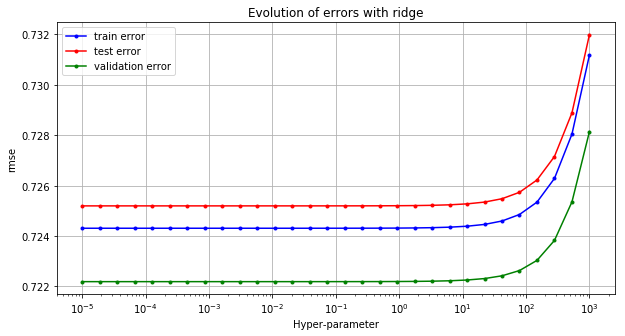

In [18]:
ridge_regression_exploration(y0, p0_product, 0.8, np.logspace(-5, 3, 30))


In [19]:
x_tr, x_te, y_tr, y_te = split_data(p0_product, y0, 0.8)
ws = ridge_regression(y_tr, x_tr, 1e-4)
y_pred = predict_labels(ws, x_te)
accuracy_calculator(y_pred, y_te)

0.7613594656096307

## Pattern 1 (Feature 0)

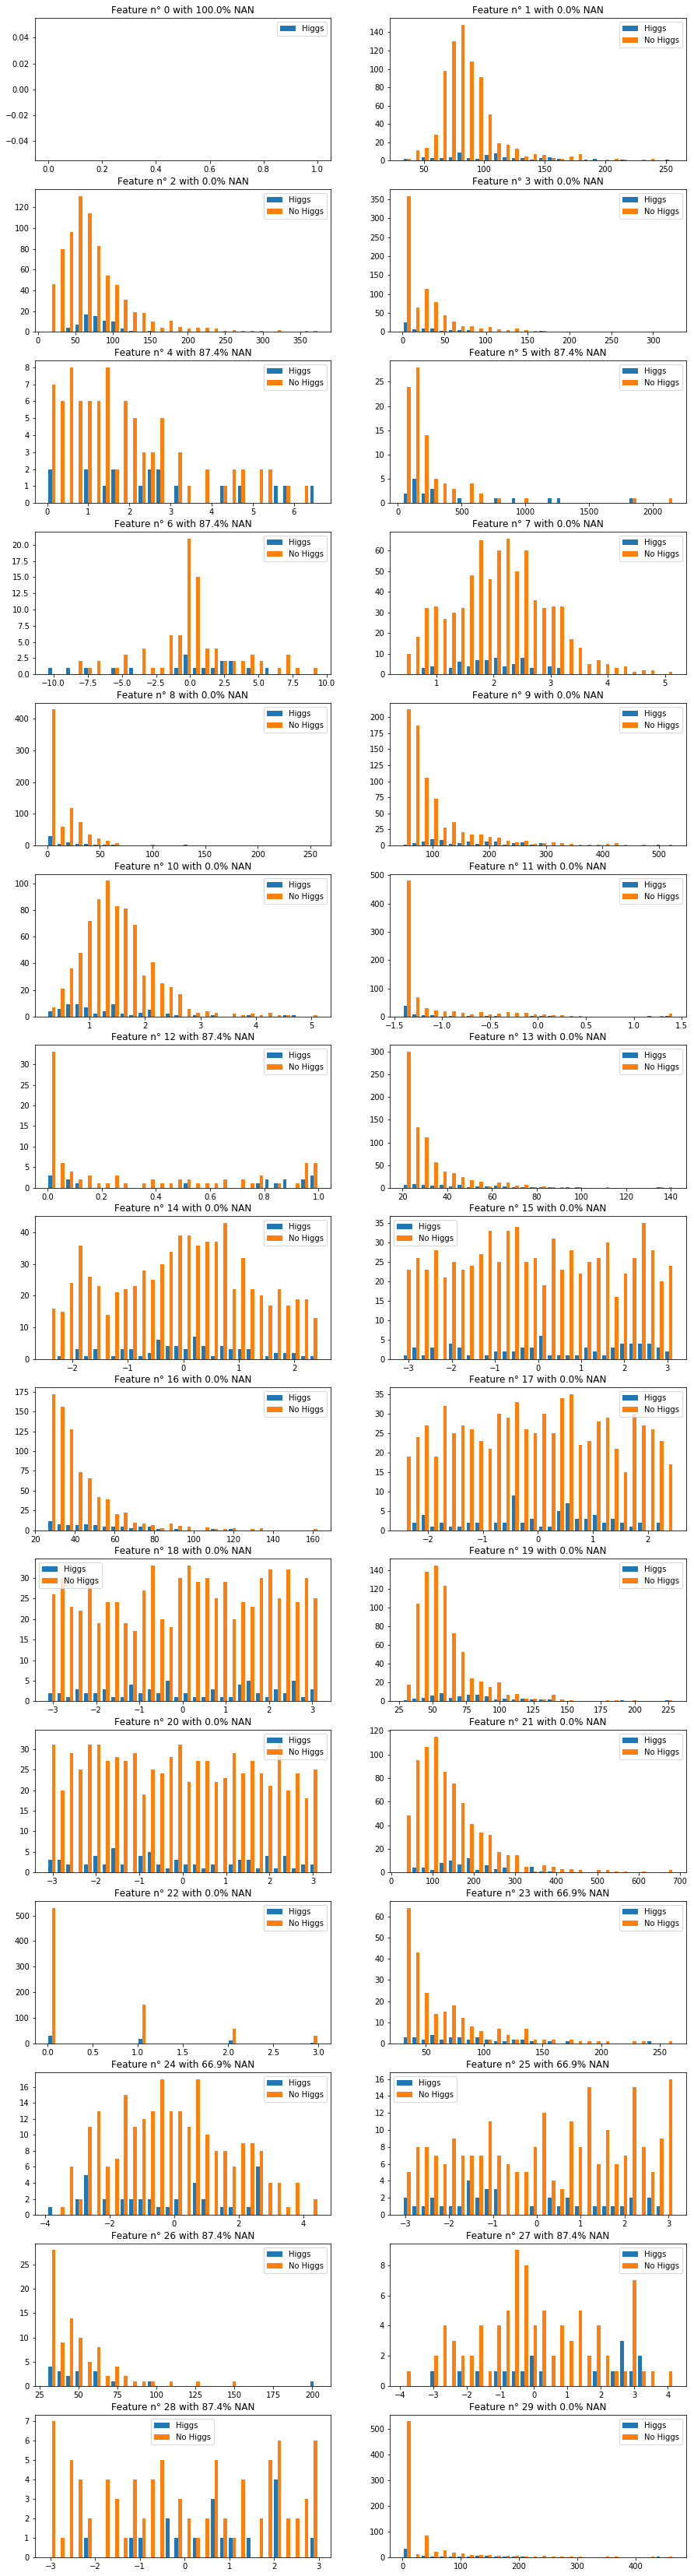

In [8]:
#display_feature_distribution(y1, p1, 30)

In [21]:
p1_nan_mean_moins = remove_constant_features(p1_nan_mean, [29, 30])
p1_eng = create_big_matrix_with_transformations(p1_nan_mean_moins)
print(p1_eng.shape)

#ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p1_eng)
a = np.ones((l,1), float)
p1_eng_plus = np.c_[a, p1_eng]

losses1, ws_l_1 = log_stochastic_gradient_descent(y1, p1_eng_plus, np.zeros(p1_eng_plus.shape[1]), 1, 1000, 1e-5)
#si converge -> dernier w qui est le meilleur: 
ws_l_1_best = ws_l_1[-1]

p1_best_final = select_best_features(p1_eng_plus, ws_l_1_best, 33, 4)

(38114, 60)
(38114, 90)
(38114, 120)
(38114, 150)
(38114, 150)
SGD(0/999): loss=0.6931471805594103, w0=0.0, w1=0.0
SGD(200/999): loss=0.6925638933236464, w0=-0.0007698764153892499, w1=-0.0002014060674491958
SGD(400/999): loss=0.6920552308427196, w0=-0.0015594008378560127, w1=-0.00032947304928467215
SGD(600/999): loss=0.69142053042118, w0=-0.0024881127601197295, w1=-0.0004368306121871294
SGD(800/999): loss=0.6908896662725115, w0=-0.0033966022368895096, w1=-0.0005636239662717717
SGD(999/999): loss=0.6902923862184003, w0=-0.0042488999606512074, w1=-0.0007520032537142095
151
[ 0. 33. 66. 67. 36.  5.  6. 71. 72. 41. 10. 75. 76. 45. 78. 79. 16. 17.
 82. 83. 84. 53. 86. 87. 88. 25. 90. 59. 60. 29. 94. 95. 96.]
33
[-4.25388176e-03  1.95180998e-05  5.59913674e-05 -9.44709785e-05
  9.82117429e-05 -4.52813771e-04  3.44898699e-04  3.26429431e-05
  2.07687301e-04  1.30185554e-04  4.80072349e-07  2.70106582e-05
 -5.51169672e-05  1.82776850e-04  1.17772361e-04  6.02745876e-05
 -6.37840483e-04  1.7549

In [37]:
cols_poly = [9, 15]
p1_polynomial = transform_feature_power(p1_best_final, cols_poly, 2 )
p1_polynomial_final = transform_feature_power(p1_polynomial, cols_poly, 3 )


p1_product = transform_feature_inter_product(p1_polynomial_final, [29, 17])
p1_product = transform_feature_inter_product(p1_product, [29, 16])
p1_product = transform_feature_inter_product(p1_product, [29, 10])
p1_product = transform_feature_inter_product(p1_product, [29, 24])
p1_product = transform_feature_inter_product(p1_product, [29, 28])
p1_product = transform_feature_inter_product(p1_product, [29, 1])





#display_feature_distribution(y1, p1_product[:, -6:], 50)




Ridge Resgression, Loss : 0.249, Lambda : 11.721022975334794


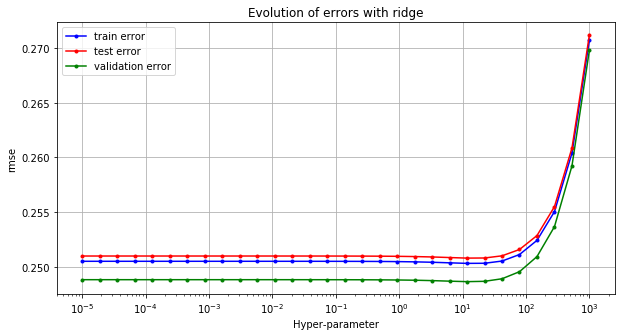

In [38]:
ridge_regression_exploration(y1, p1_product, 0.8, np.logspace(-5, 3, 30))


In [41]:
x_tr, x_te, y_tr, y_te = split_data(p1_product, y1, 0.8)

initial_w_gd = np.zeros(p1_product.shape[1])

max_iters = 20000
batch=10
gamma = 0.01
gd_l1,gd_w1=log_stochastic_gradient_descent(y_tr, x_tr, initial_w_gd, batch, max_iters, gamma)

l,wnew1=minimum_loss_vector(gd_l1, gd_w1)
l,wnew1.shape

SGD(0/19999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.2595496347280381, w0=-1.5065098323284265, w1=0.03403305647495594
SGD(8000/19999): loss=0.27500027484768974, w0=-1.8207731942561491, w1=0.030516311713592148
SGD(12000/19999): loss=0.2301470013525095, w0=-1.9737761042415636, w1=-0.02104441760628293
SGD(16000/19999): loss=0.24466299236716152, w0=-2.0821541578996294, w1=0.03271683122474234
SGD(19999/19999): loss=0.23616051251737885, w0=-2.132868470235332, w1=-0.026406429383213817


(0.2301470013525095, (43,))

In [44]:
x_tr, x_te, y_tr, y_te = split_data(p1_product, y1, 0.8)
ws = ridge_regression(y_tr, x_tr, 1)

In [60]:
y_pred1 = predict_labels_logi(wnew1 , x_te)
accuracy_calculator(y_pred1, y_te)

7515
33
75


0.9279811097992916

In [56]:
np.count_nonzero([y_pred==-1])

7557

## Pattern 2 (Feature 23)

IndexError: index 16 is out of bounds for axis 0 with size 16

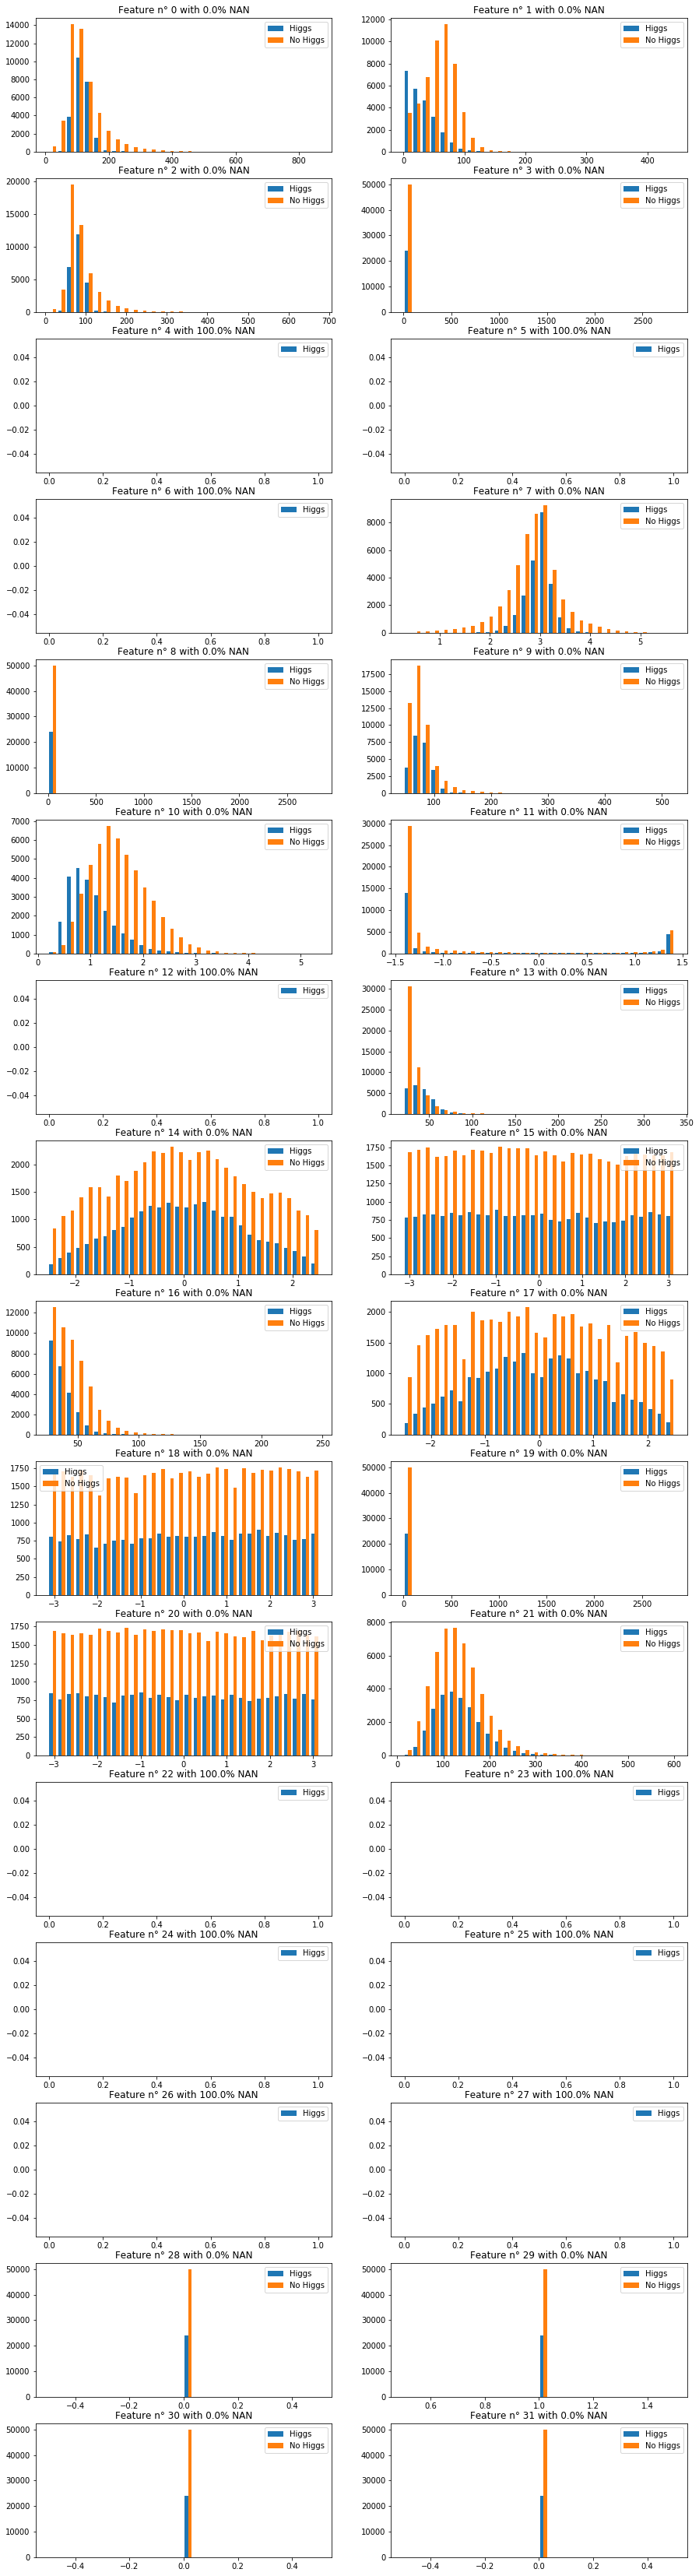

In [61]:
#display_feature_distribution(y2, p2, 30)

In [64]:
p2_nan_mean_moins = remove_constant_features(p2_nan_mean, [18, 19, 20, 21, 22])
p2_eng = create_big_matrix_with_transformations(p2_nan_mean_moins)
print(p2_eng.shape)

#ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p2_eng)
a = np.ones((l,1), float)
p2_eng_plus = np.c_[a, p2_eng]

losses2, ws_l_2 = log_stochastic_gradient_descent(y2, p2_eng_plus, np.zeros(p2_eng_plus.shape[1]), 1, 1000, 1e-2)
#si converge -> dernier w qui est le meilleur: 
ws_l_2_best = ws_l_2[-1]

p2_best_final = select_best_features(p2_eng_plus, ws_l_2_best, 24, 4)

(73790, 36)
(73790, 54)
(73790, 72)
(73790, 90)
(73790, 90)
SGD(0/999): loss=0.6931471805588729, w0=0.0, w1=0.0
SGD(200/999): loss=0.5296921577105533, w0=-0.30478675734786975, w1=0.05564837688367891
SGD(400/999): loss=0.5165875377973251, w0=-0.42238827812000634, w1=0.06586631809877753
SGD(600/999): loss=0.4817680633321703, w0=-0.5859398450935811, w1=0.09160721977883723
SGD(800/999): loss=0.48238035847074384, w0=-0.6216606350769356, w1=0.12746236524620233
SGD(999/999): loss=0.471991805985534, w0=-0.7470286936209106, w1=0.14244068210825767
91
[ 0. 24.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 41. 19. 20. 21. 22. 23.]
24
[-0.74158914  0.02093514  0.15418643  0.3061539  -0.01638659 -0.09123277
 -0.01638659  0.00268267  0.07569178 -0.04573608 -0.04860272  0.03831261
  0.03278758  0.05408666  0.03586574  0.02680394  0.00427025  0.00544611
  0.29331884  0.0026359   0.14862213  0.02225525  0.02093517  0.10674946]


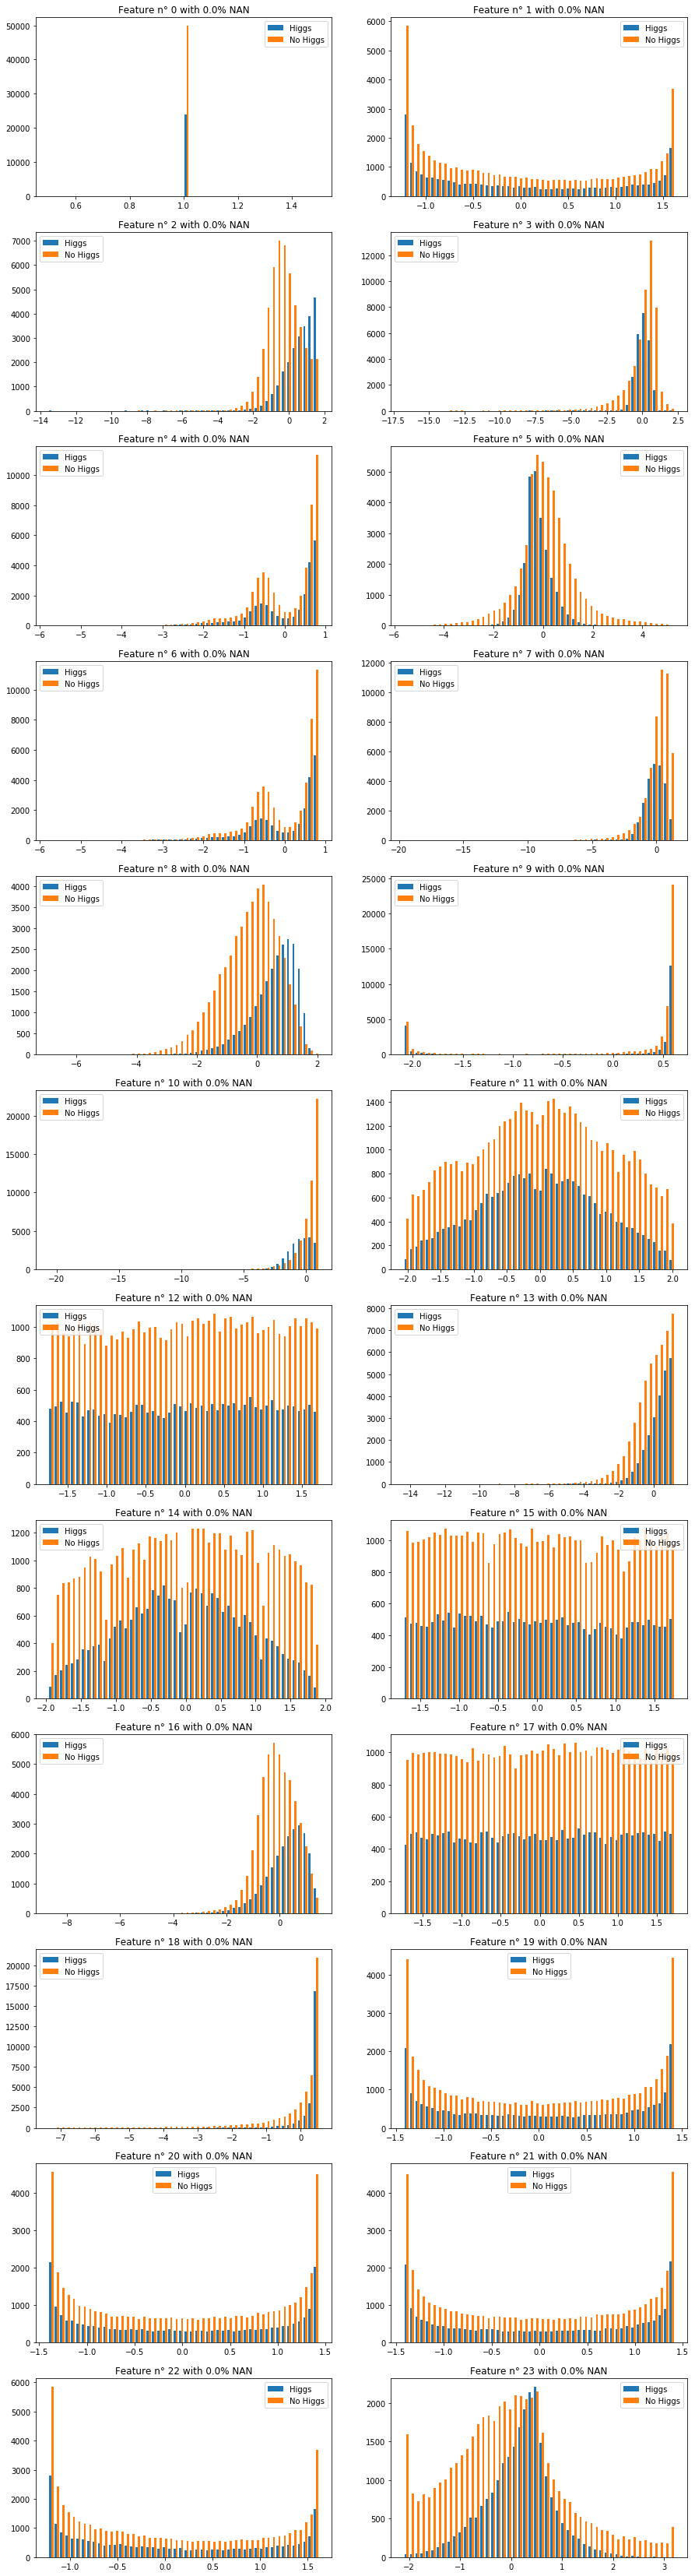

In [65]:
#display_feature_distribution(y2, p2_best_final, 50)

In [127]:
p2_best_final.shape

(73790, 24)

In [138]:
p2_polynomial_final.shape

(73790, 40)

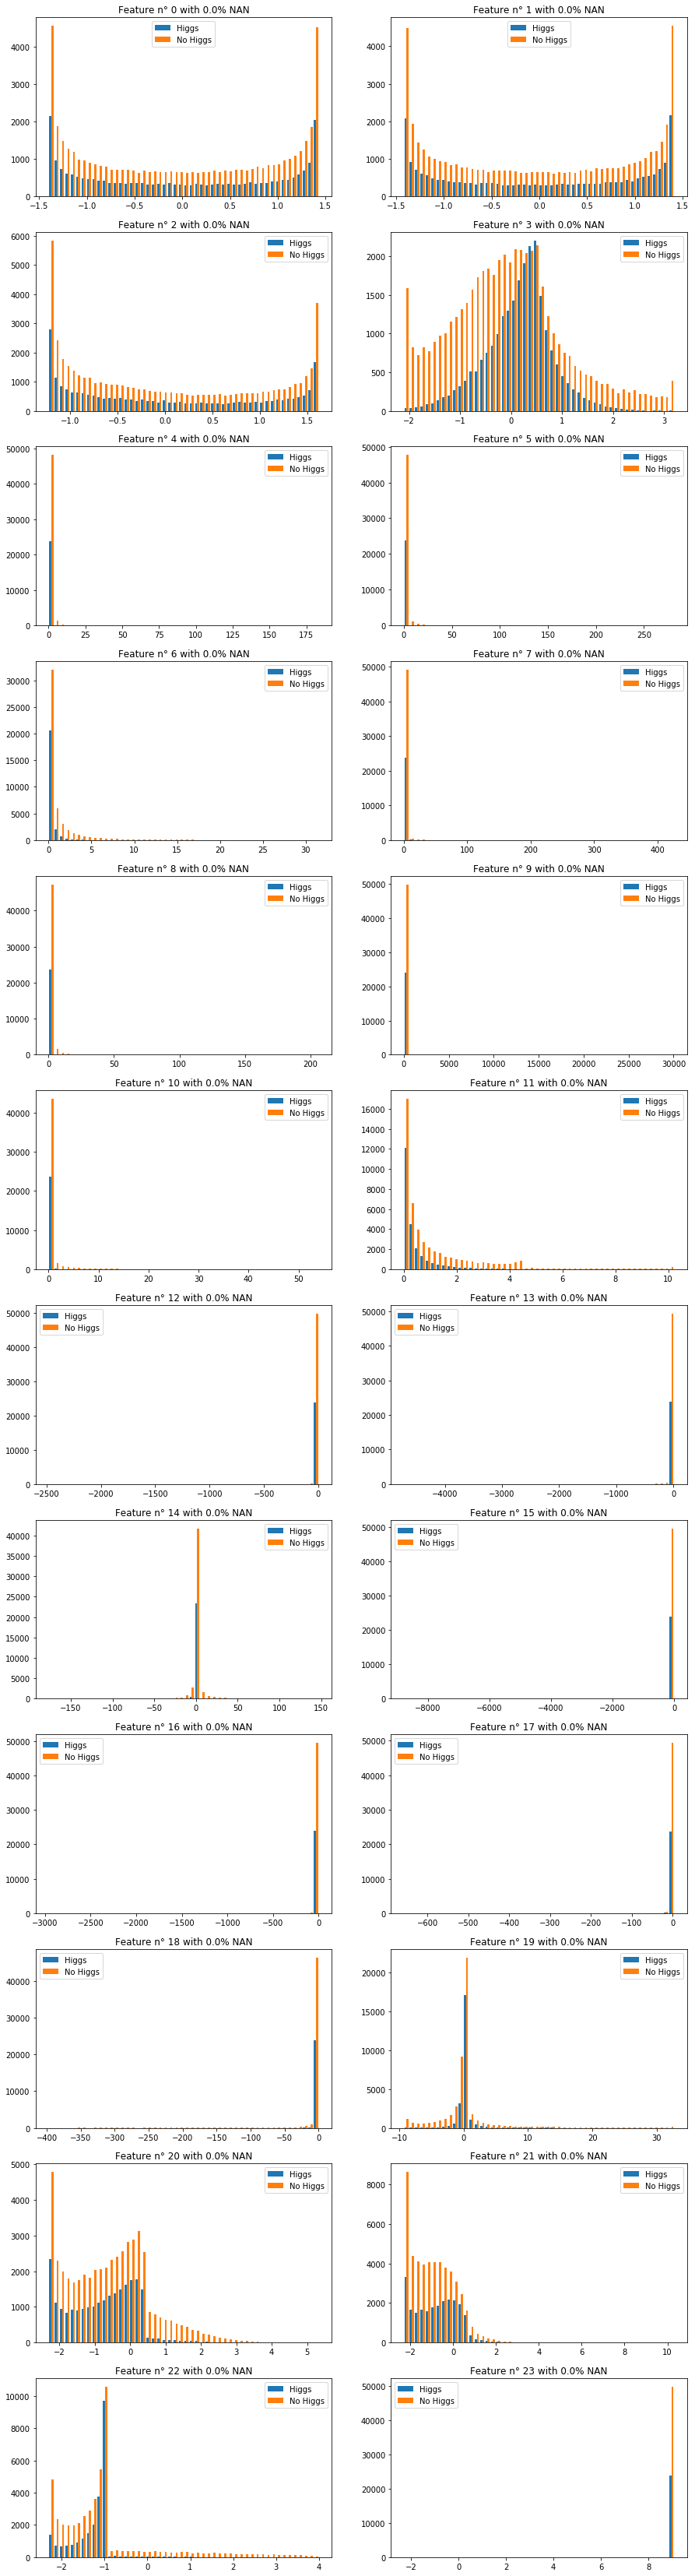

In [133]:
cols_poly = [2, 3, 5, 10, 13, 16, 18, 23]
p2_polynomial = transform_feature_power(p2_best_final, cols_poly, 2 )
p2_polynomial_final = transform_feature_power(p2_polynomial, cols_poly, 3 )

p2_polynomial_log = transform_feature_log(p2_polynomial_final, [28, 29, 30, 35])
#display_feature_distribution(y2, p2_polynomial_log[:, -24:], 50)

In [139]:
p2_product = transform_feature_inter_product(p2_polynomial_log, [9, 25])
p2_product = transform_feature_inter_product(p2_product, [9, 6])
p2_product = transform_feature_inter_product(p2_product, [9, 5])
p2_product = transform_feature_inter_product(p2_product, [9, 10])
p2_product = transform_feature_inter_product(p2_product, [9, 11])
p2_product = transform_feature_inter_product(p2_product, [9, 12])
p2_product = transform_feature_inter_product(p2_product, [9, 13])
p2_product = transform_feature_inter_product(p2_product, [9, 14])
p2_product = transform_feature_inter_product(p2_product, [9, 23])
p2_product = transform_feature_inter_product(p2_product, [9, 16])


#feature_true, feature_false, nb_nan = split_data_according_to_truth(p2_product, y2)
#plt.hist([feature_true, feature_false], histtype = 'bar',bins=50, label=['Higgs', 'No Higgs'])
#plt.show()
#display_feature_distribution(y2, p2_product[:,-12:], 50)

In [141]:
p2_polynomial_log.shape

(73790, 44)

Ridge Resgression, Loss : 0.647, Lambda : 1.3738237958832666


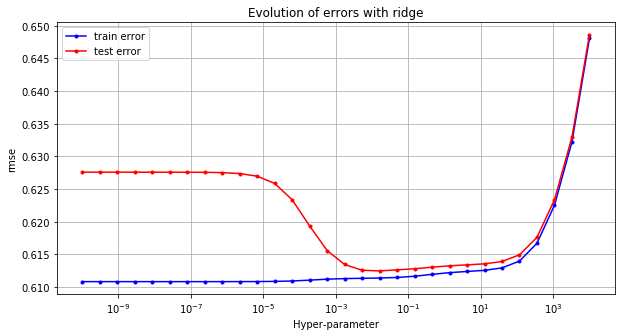

In [142]:
ridge_regression_exploration(y2, p2_product, 0.8, np.logspace(-10, 4, 30))

In [147]:
x_tr, x_te, y_tr, y_te = split_data(p2_product, y2, 0.8)
ws2 = ridge_regression(y_tr, x_tr, 1e-2)
y_pred2 = predict_labels(ws2, x_te)
accuracy_calculator(y_pred2, y_te)

0.7943488277544383

In [99]:
x_tr, x_te, y_tr, y_te = split_data(p2_product, y2, 0.8)

initial_w_gd = np.zeros(p2_product.shape[1])
max_iters = 20000
batch=10
gamma = 0.01
gd_l2,gd_w2=log_stochastic_gradient_descent(y_tr, x_tr, initial_w_gd, batch, max_iters, gamma)

l,wnew2=minimum_loss_vector(gd_l2, gd_w2)
l,wnew2.shape

SGD(0/19999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.6088026958156275, w0=-0.026621554246940644, w1=-0.011945381608166066
SGD(8000/19999): loss=1.6876072974211862, w0=-0.27598690630742073, w1=0.0010812049412160414
SGD(12000/19999): loss=0.5463646245881019, w0=-0.17384551754835098, w1=-0.0011824606672302723
SGD(16000/19999): loss=0.9029084464715406, w0=-0.2627257922796047, w1=0.033626363245506205
SGD(19999/19999): loss=0.872616629603211, w0=-0.28945373415022796, w1=-0.03201530244193107


(0.5463646245881019, (54,))

In [102]:
y_pred4=predict_labels(wnew2, x_te)

accuracy_calculator(y_pred4, y_te)

0.8036319284455888

## Pattern 3 (Feature 28)

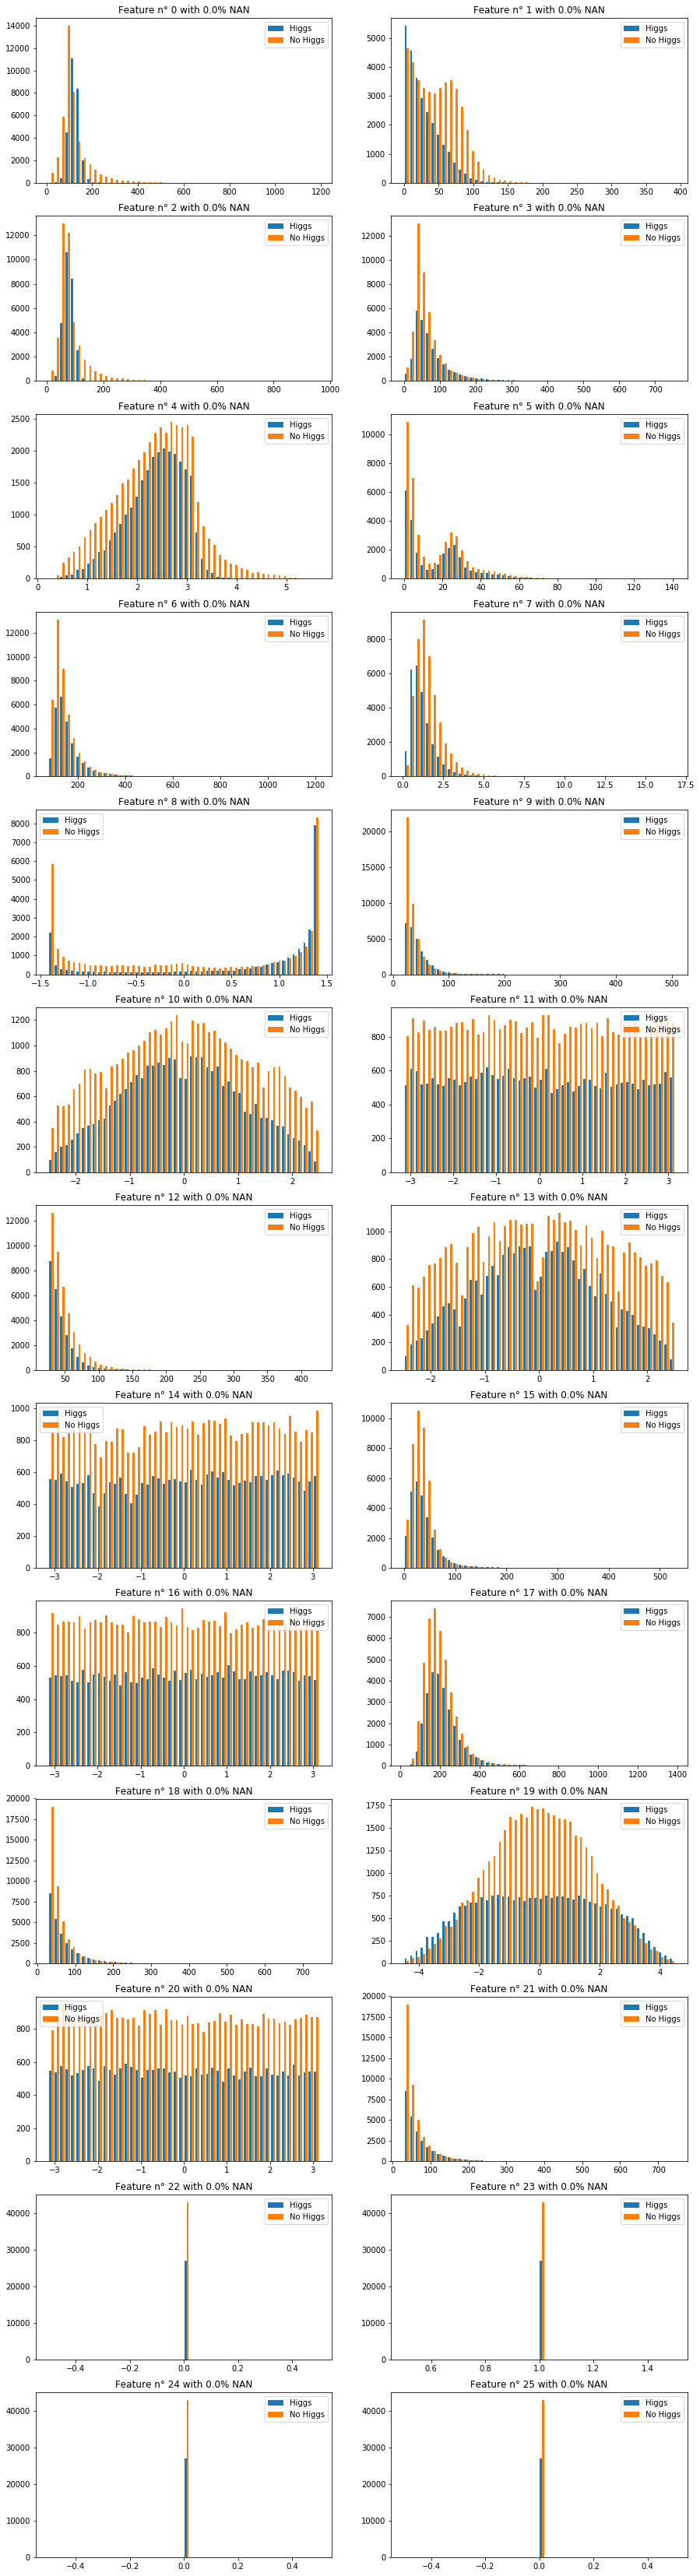

In [156]:
#display_feature_distribution(y3, p3_nan_mean, 50)

In [148]:
p3_nan_mean_moins.shape

(69982, 22)

In [103]:
p3_nan_mean_moins = remove_constant_features(p3_nan_mean, [22, 23, 24, 25])
p3_eng = create_big_matrix_with_transformations(p3_nan_mean_moins)
print(p3_eng.shape)

#ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p3_eng)
a = np.ones((l,1), float)
p3_eng_plus = np.c_[a, p3_eng]

losses3, ws_l_3 = log_stochastic_gradient_descent(y3, p3_eng_plus, np.zeros(p3_eng_plus.shape[1]), 1, 1000, 1e-2)
#si converge -> dernier w qui est le meilleur: 
ws_l_3_best = ws_l_3[-1]

p3_best_final = select_best_features(p3_eng_plus, ws_l_3_best, 23, 4)

(69982, 44)
(69982, 66)
(69982, 88)
(69982, 110)
(69982, 110)
SGD(0/999): loss=0.6931471805589041, w0=0.0, w1=0.0
SGD(200/999): loss=0.6309293663239993, w0=-0.26178906612362457, w1=0.09246882007130015
SGD(400/999): loss=0.5916152435161476, w0=-0.26142733868197404, w1=0.13374109530866737
SGD(600/999): loss=0.5861425994521271, w0=-0.3332138434129962, w1=0.13133746219890222
SGD(800/999): loss=0.5605317411699144, w0=-0.45018988121235937, w1=0.17782374502977014
SGD(999/999): loss=0.549292924716578, w0=-0.42746595268749943, w1=0.16241413282345638
111
[ 0. 23. 46. 25.  4. 49.  6. 51. 30.  9. 54. 33. 12. 35. 14. 59. 16. 39.
 18. 41. 64. 21. 44.]
23
[-0.43231528  0.01207396  0.02644207  0.06371293 -0.11542991  0.33679139
 -0.04202838  0.08533711  0.03044115 -0.03604394  0.0821389   0.06301099
  0.01787383  0.03576214 -0.01016733  0.09439215 -0.02608065  0.06590587
  0.05307811  0.03783151  0.34466933  0.03471943  0.0378166 ]


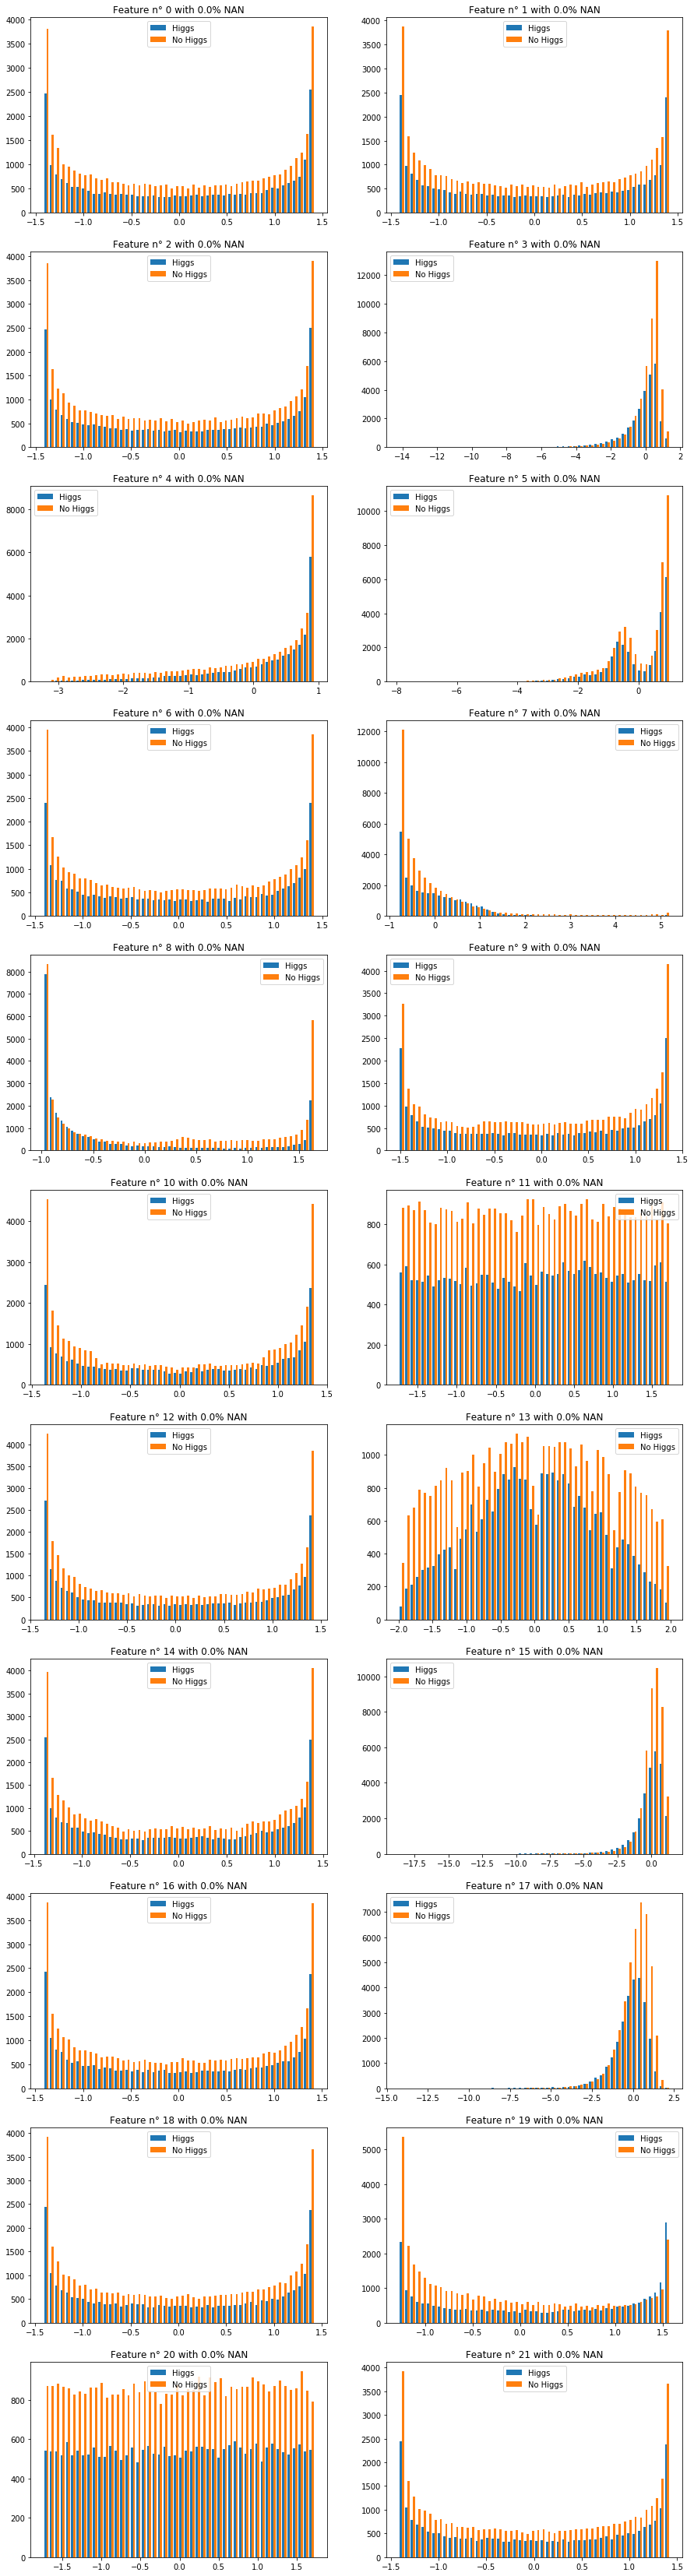

In [106]:
#display_feature_distribution(y3, p3_best_final[:,1:], 50)

In [121]:
p3_best_final.shape

(69982, 23)

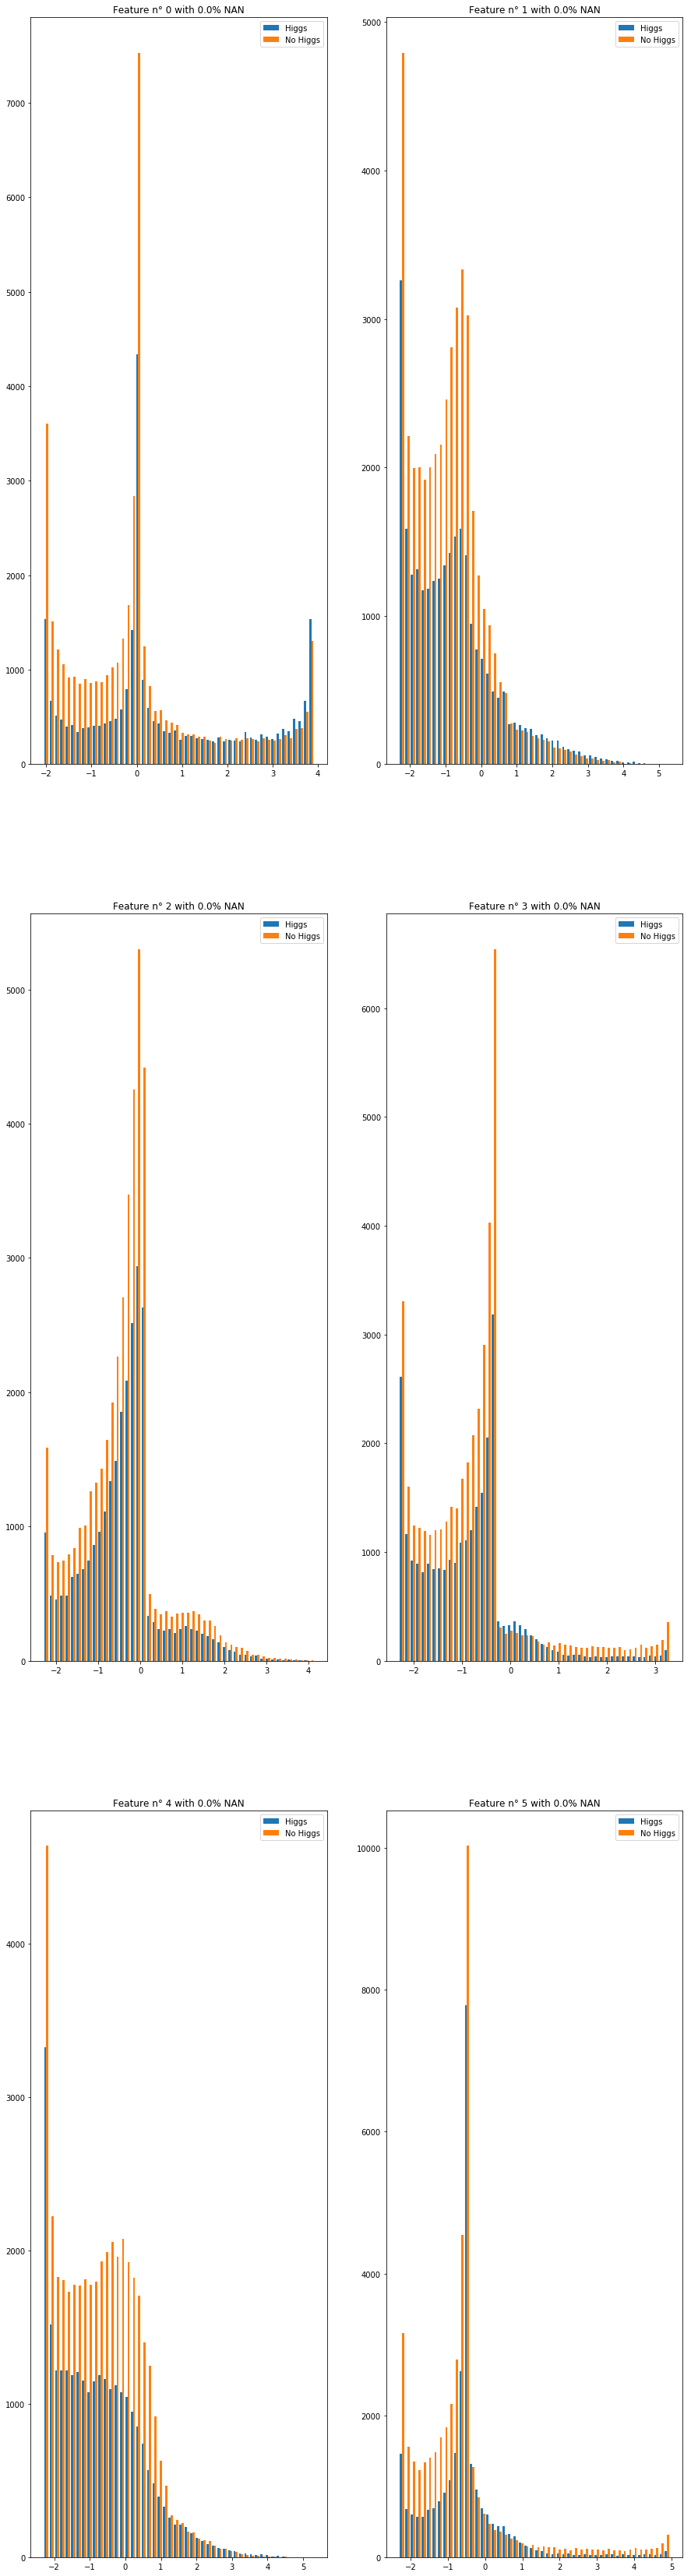

In [125]:
cols_poly = [4, 5, 6, 8, 9, 18, 20]
p3_polynomial = transform_feature_power(p3_best_final, cols_poly, 2 )
p3_polynomial_final = transform_feature_power(p3_polynomial, cols_poly, 3 )

p3_polynomial_log = transform_feature_log(p3_polynomial_final, [23, 25, 26, 28, 33])
#display_feature_distribution(y3, p3_polynomial_log[:, -6:], 50)

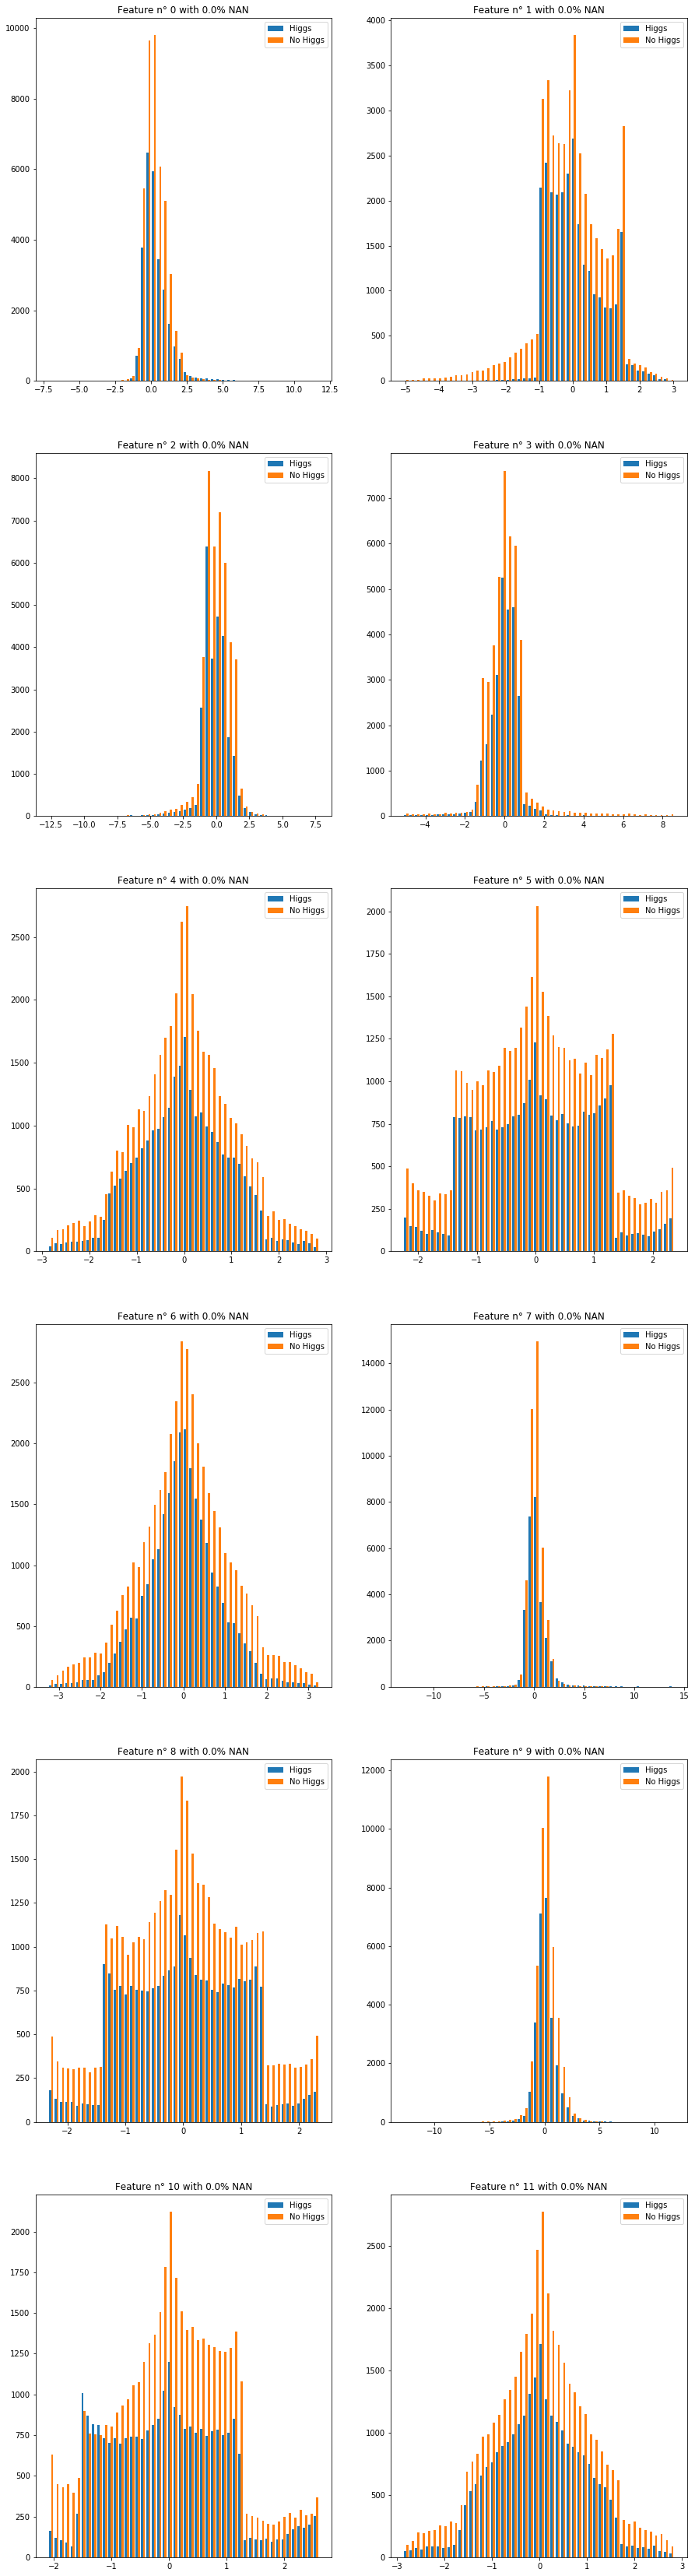

In [117]:
p3_product = transform_feature_inter_product(p3_product, [9, 4])
p3_product = transform_feature_inter_product(p3_product, [9, 5])
p3_product = transform_feature_inter_product(p3_product, [9, 6])
p3_product = transform_feature_inter_product(p3_product, [9, 8])
p3_product = transform_feature_inter_product(p3_product, [9, 12])
p3_product = transform_feature_inter_product(p3_product, [9, 13])
p3_product = transform_feature_inter_product(p3_product, [9, 14])
p3_product = transform_feature_inter_product(p3_product, [9, 16])
p3_product = transform_feature_inter_product(p3_product, [9, 17])
p3_product = transform_feature_inter_product(p3_product, [9, 18])
p3_product = transform_feature_inter_product(p3_product, [9, 20])
p3_product = transform_feature_inter_product(p3_product, [9, 21])



#display_feature_distribution(y3, p3_product[:, -12:], 50)

Ridge Resgression, Loss : 0.796, Lambda : 1e-10


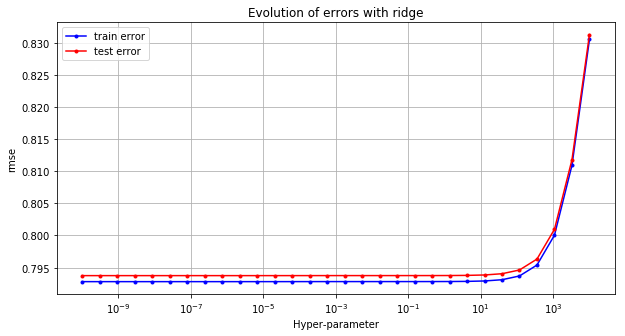

In [157]:
ridge_regression_exploration(y3, p3_product, 0.8, np.logspace(-10, 4, 30))

In [158]:
x_tr, x_te, y_tr, y_te = split_data(p3_product, y3, 0.8)
ws3 = ridge_regression(y_tr, x_tr, 1e-5)
y_pred3 = predict_labels(ws3, x_te)
accuracy_calculator(y_pred3, y_te)

0.700578695434736

In [160]:
x_tr, x_te, y_tr, y_te = split_data(p2_product, y2, 0.8)

initial_w_gd = np.zeros(p2_product.shape[1])
max_iters = 20000
batch=10
gamma = 0.001
gd_l2,gd_w2=log_stochastic_gradient_descent(y_tr, x_tr, initial_w_gd, batch, max_iters, gamma)

l,wnew2=minimum_loss_vector(gd_l2, gd_w2)
l,wnew2.shape

SGD(0/19999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.47668114837980485, w0=-0.003911455611584683, w1=-0.00032385613622262104
SGD(8000/19999): loss=0.469124942539541, w0=-0.004418086159934392, w1=0.0023123647240312767
SGD(12000/19999): loss=0.4555818646324639, w0=-0.0052016740267719725, w1=0.002697932575817438
SGD(16000/19999): loss=0.46360263912430744, w0=-0.004554360597051203, w1=0.006077447952892721
SGD(19999/19999): loss=0.463560182368666, w0=-0.005101572962777669, w1=-0.0007213559067477202


(0.4555818646324639, (54,))

In [161]:
y_pred4=predict_labels(wnew2, x_te)

accuracy_calculator(y_pred4, y_te)

0.7990920178886028

# Train Models 

In [14]:
from train_model import *

## P0

In [11]:
feature_nans = [22]
p0_processed = np.delete(p0_processed, feature_nans, axis = 1)

Ridge Resgression, Loss : 0.741, Lambda : 1e-10


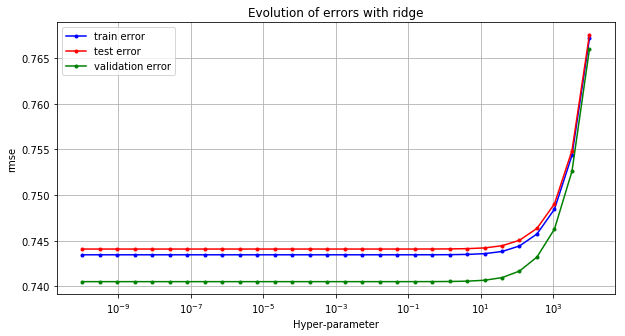

In [341]:
ridge_regression_exploration(y0, p0_processed, 0.8, np.logspace(-10, 4, 30))

Gradient Descent, Loss : 0.815, Lambda : 0.0007880462815669905


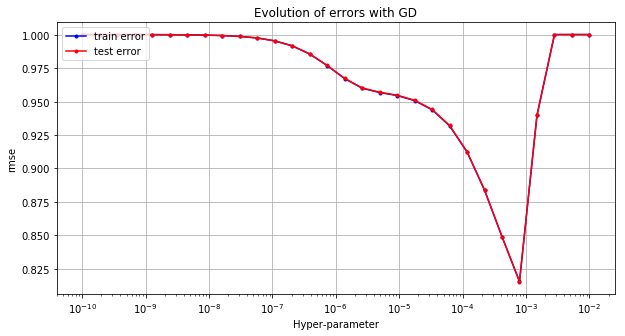

In [340]:
max_iter = 500
initial_w = np.zeros(p0_processed.shape[1])
gradient_descent_exploration(y0, p0_processed, 0.8, np.logspace(-10, -2, 30), initial_w, max_iter)

In [ ]:
from train_model import *
max_iter = 2000
initial_w = np.zeros(p0_processed.shape[1])
logistic_stochastic_gradient_descent_exploration(y0, p0_processed, 0.8, np.logspace(-10, -2, 10), 1, initial_w, max_iter)

In [72]:
_, ws0_best = log_stochastic_gradient_descent(y0, p0_processed, initial_w, 1, max_iter, 1.6e-4)

SGD(0/1999): loss=0.6931471805589208, w0=0.0, w1=0.0
SGD(400/1999): loss=-4.6070332318253175, w0=0.01115500389382911, w1=-0.4841067237686519
SGD(800/1999): loss=-12.427419423988681, w0=0.020948321184252997, w1=-1.2968910856179288
SGD(1200/1999): loss=-15.482779934520249, w0=0.02950004650453188, w1=-1.6127492108945398
SGD(1600/1999): loss=-22.18605400785666, w0=0.040365002684426055, w1=-2.3107910186193243


In [73]:
ws0_best = ws0_best[-1]

## P1

In [28]:
feature_nans = [0, 22]
p1_processed = np.delete(p1_processed, feature_nans, axis = 1)

Gradient Descent, Loss : 0.815, Lambda : 0.0007880462815669905


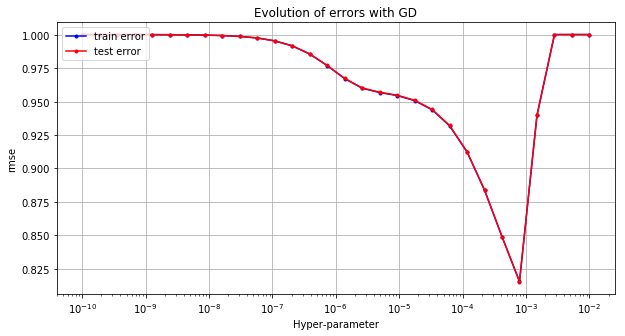

In [29]:
max_iter = 500
initial_w = np.zeros(p0_processed.shape[1])
gradient_descent_exploration(y0, p0_processed, 0.8, np.logspace(-10, -2, 30), initial_w, max_iter)

Ridge Resgression, Loss : 0.256, Lambda : 1e-10


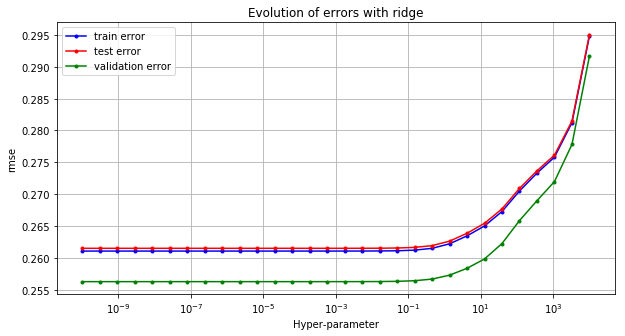

In [32]:
ridge_regression_exploration(y1, p1_processed, 0.8, np.logspace(-10, 4, 30))

SGD(0/1999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(400/1999): loss=0.4494110694600753, w0=-0.009146278179590918, w1=2.5079738708895254e-05
SGD(800/1999): loss=0.373024609951613, w0=-0.01481780181343066, w1=4.92878271507292e-05
SGD(1200/1999): loss=0.3503511518334451, w0=-0.017702048261145457, w1=6.974784961642499e-05
SGD(1600/1999): loss=0.337886467280642, w0=-0.020171195449439138, w1=8.099351417818305e-05
SGD(0/1999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(400/1999): loss=0.3657577283796198, w0=-0.015620506231456055, w1=5.73437055781793e-05
SGD(800/1999): loss=0.33213182695764004, w0=-0.022026444352189107, w1=9.813857482827148e-05
SGD(1200/1999): loss=0.33179362854848893, w0=-0.02215820859127572, w1=0.0001375599122758389
SGD(1600/1999): loss=0.3283566808663674, w0=-0.02486839426868037, w1=0.00018028006683385751
SGD(0/1999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(400/1999): loss=0.3286773131690294, w0=-0.024359286005599966, w1=6.1576513076751e-05
SGD(800/1999): loss=0.3

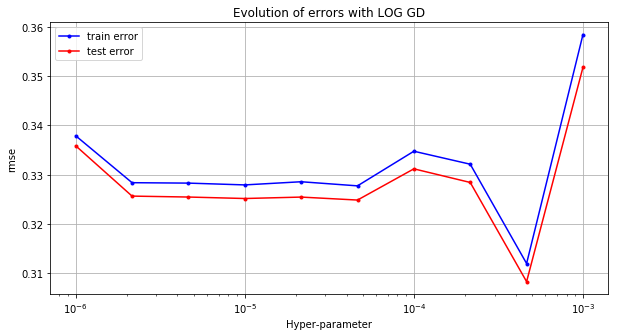

In [36]:
from train_model import *
max_iter = 2000
initial_w = np.zeros(p1_processed.shape[1])
logistic_stochastic_gradient_descent_exploration(y1, p1_processed, 0.8, np.logspace(-6, -3, 10), 1, initial_w, max_iter)

In [76]:
initial_w = np.zeros(p1_processed.shape[1])

_, ws1_best = log_stochastic_gradient_descent(y1, p1_processed, initial_w, 1, max_iter, 4e-4)

SGD(0/1999): loss=0.6931471805594103, w0=0.0, w1=0.0
SGD(400/1999): loss=-883.4008528561367, w0=-12.133895581851224, w1=0.0031810088505304524
SGD(800/1999): loss=-1728.1430564237346, w0=-23.736419981851228, w1=0.014507640817008503
SGD(1200/1999): loss=-2540.838545953461, w0=-34.89894158185121, w1=0.024536683334826944
SGD(1600/1999): loss=-3401.9527008238983, w0=-46.726627981851166, w1=0.02899657123881793


In [77]:
ws1_best = ws1_best[-1]

## P2

In [43]:
feature_nans = [4,5,6,12,22, 23 ,24, 25, 26,27,28]
p2_processed = np.delete(p2_processed, feature_nans, axis = 1)

Ridge Resgression, Loss : 0.638, Lambda : 1e-10


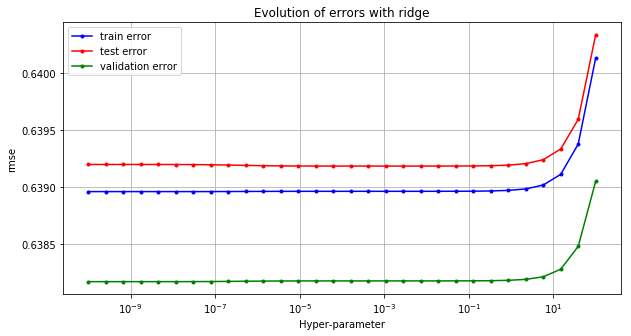

In [44]:
ridge_regression_exploration(y2, p2_processed, 0.8, np.logspace(-10, 2, 30))

/home/hadrien/ML/local/projects/project1/ML_methods.py:267: RuntimeWarning: invalid value encountered in subtract
  w = w - gamma * grad


Gradient Descent, Loss : 0.684, Lambda : 0.00041753189365604


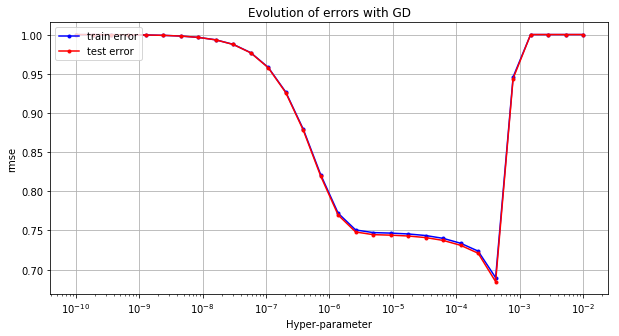

In [45]:
max_iter = 500
initial_w = np.zeros(p2_processed.shape[1])
gradient_descent_exploration(y2, p2_processed, 0.8, np.logspace(-10, -2, 30), initial_w, max_iter)

SGD(0/1999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(400/1999): loss=0.5783406755338864, w0=0.0017705611893931038, w1=-0.03492659344828429
SGD(800/1999): loss=0.5510290689078067, w0=0.003730598295368082, w1=-0.027867178066990753
SGD(1200/1999): loss=0.5566339486765141, w0=0.0035547291276613316, w1=-0.03143549915457935
SGD(1600/1999): loss=0.5504802492089826, w0=0.004369926010377909, w1=-0.03067801062532858
SGD(0/1999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(400/1999): loss=0.5490495232047664, w0=0.0035953261950901864, w1=-0.02824417656769189
SGD(800/1999): loss=0.6159198297984715, w0=0.005452091037070404, w1=-0.04630104285306616
SGD(1200/1999): loss=0.5488428295986649, w0=0.007249435161479784, w1=-0.03383102276896508
SGD(1600/1999): loss=0.5773131497669227, w0=0.013905625744063893, w1=-0.043008488200969176
SGD(0/1999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(400/1999): loss=0.5772008746201817, w0=0.002308164403429332, w1=-0.04215581158775513
SGD(800/1999): loss=0.710654074

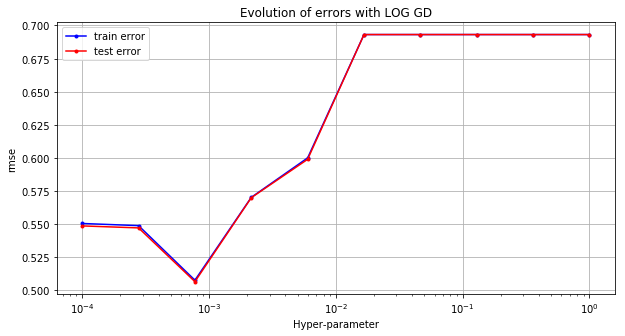

In [47]:
from train_model import *
max_iter = 2000
initial_w = np.zeros(p2_processed.shape[1])
logistic_stochastic_gradient_descent_exploration(y2, p2_processed, 0.8, np.logspace(-4, 0, 10), 1, initial_w, max_iter)

In [78]:
ws2_best = ridge_regression(y2, p2_processed, 1e-3)

## P3

In [49]:
feature_nans = [4,5,6,12,22, 26,27,28]
p3_processed = np.delete(p3_processed, feature_nans, axis = 1)

Ridge Resgression, Loss : 0.789, Lambda : 41.753189365604086


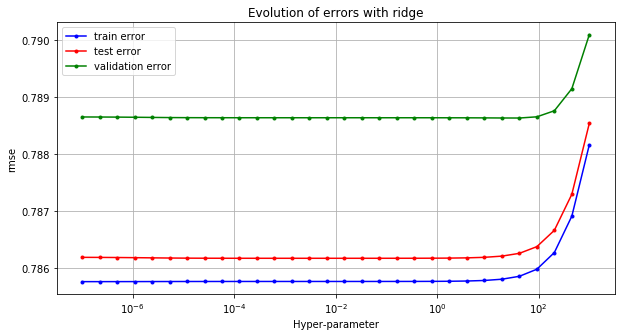

In [50]:
ridge_regression_exploration(y3, p3_processed, 0.8, np.logspace(-7, 3, 30))

Gradient Descent, Loss : 0.834, Lambda : 0.0007880462815669905


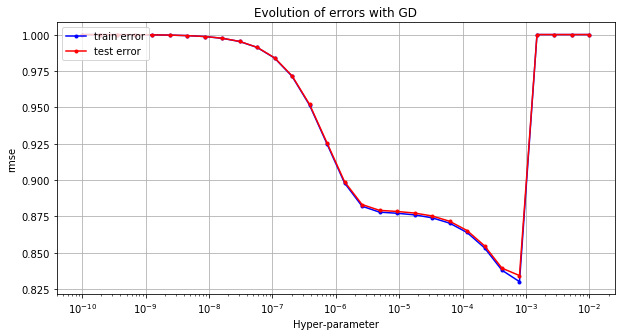

In [51]:
max_iter = 500
initial_w = np.zeros(p3_processed.shape[1])
gradient_descent_exploration(y3, p3_processed, 0.8, np.logspace(-10, -2, 30), initial_w, max_iter)

SGD(0/9999): loss=0.6931471805590554, w0=0.0, w1=0.0
SGD(2000/9999): loss=0.6350480291667288, w0=0.00017155408544748473, w1=-0.010015593319211561
SGD(4000/9999): loss=0.6281732236707542, w0=0.00034859712128141343, w1=-0.013690305893764824
SGD(6000/9999): loss=0.6274691867087742, w0=0.0005169256452922766, w1=-0.01448976524601413
SGD(8000/9999): loss=0.627046537862723, w0=0.0006889501953637279, w1=-0.015410060590509029
SGD(0/9999): loss=0.6931471805590554, w0=0.0, w1=0.0
SGD(2000/9999): loss=0.6273554722167294, w0=0.0004957269322796973, w1=-0.014773035615263467
SGD(4000/9999): loss=0.6268142189421185, w0=0.001008227026243969, w1=-0.015490309289576627
SGD(6000/9999): loss=0.6264946369701526, w0=0.0014955270561233596, w1=-0.015125094834288876
SGD(8000/9999): loss=0.6260601036566562, w0=0.001977095693006816, w1=-0.015752722985405594
SGD(0/9999): loss=0.6931471805590554, w0=0.0, w1=0.0
SGD(2000/9999): loss=0.626549428253299, w0=0.001443666195830726, w1=-0.015443998805873016
SGD(4000/9999): l

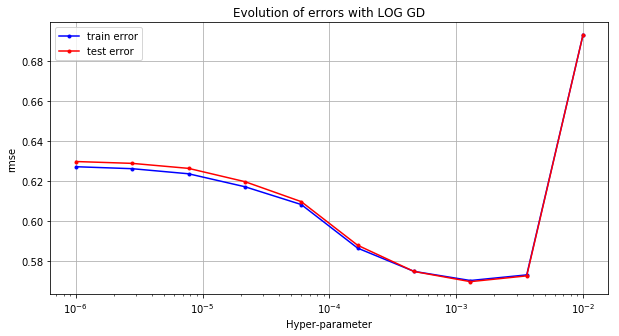

In [96]:
from train_model import *
max_iter = 10000
initial_w = np.zeros(p3_processed.shape[1])
logistic_stochastic_gradient_descent_exploration(y3, p3_processed, 0.8, np.logspace(-6, -2, 10), 10, initial_w, max_iter)

In [82]:
initial_w = np.zeros(p3_processed.shape[1])

_, ws3_best = log_stochastic_gradient_descent(y3, p3_processed, initial_w, 1, max_iter, 4e-4)

SGD(0/1999): loss=0.6931471805589041, w0=0.0, w1=0.0
SGD(400/1999): loss=-55.985878729390755, w0=0.046197430169942995, w1=-3.1305337645905453
SGD(800/1999): loss=-117.58545811413224, w0=0.08533967622907077, w1=-6.574605582448392
SGD(1200/1999): loss=-159.39494664316425, w0=0.11660976357025438, w1=-8.912623453299062
SGD(1600/1999): loss=-198.7394446997183, w0=0.1547603936385213, w1=-11.111035304863998


In [83]:
ws3_best=ws3_best[-1]
ws3_best.shape

(26,)

# Test Models

In [84]:
y_te, tx_te, ids_te = load_csv_data("data_csv/test.csv", sub_sample=False)
print("y has shape {0}".format(y.shape))
print("X has shape {0}".format(tx.shape))

y has shape (250000,)
X has shape (250000, 30)


In [85]:
tx_te_nan = transform_to_nan(tx_te, -900)
p0_ind_te, p0_te, y0_te, p1_ind_te, p1_te, y1_te, p2_ind_te, p2_te, y2_te, p3_ind_te, p3_te, y3_te = decompose_dataset_according_to_NAN_pattern(tx_te_nan, y_te)

In [86]:
def basic_features_process_te(tx, nan_mean):
    
    tx_nan_mean, nan_mean = transform_to_mean(tx)
    
    features_square = [6]
    tx_square = transform_feature_power(tx_nan_mean, features_square, 2)

    features_log = [0, 2, 3, 5, 6, 8, 9, 10, 13, 16, 19, 21, 23, 26, 29]
    tx_log = transform_feature_log(tx_square, features_log)

    features_sin = [11, 12, 14, 15, 17]
    tx_angle_stand = standardize_angles(tx_log, features_sin)
    tx_sin = transform_feature_sin(tx_angle_stand, features_sin)

    feature_std = features_log
    tx_std, mean, std = standardize_features(tx_sin, feature_std)

    tx_22plus0 = new_feature_PRI_jet_num(tx_std, 0.0)
    tx_22plus1 = new_feature_PRI_jet_num(tx_22plus0, 1.0)
    tx_22plus2 = new_feature_PRI_jet_num(tx_22plus1, 2.0)
    tx_22plus3 = new_feature_PRI_jet_num(tx_22plus2, 3.0)
    
    return tx_22plus3

In [87]:
p0_te_processed = basic_features_process_te(p0_te, nan_mean0)
p1_te_processed = basic_features_process_te(p1_te, nan_mean1)
p2_te_processed = basic_features_process_te(p2_te, nan_mean2)
p3_te_processed = basic_features_process_te(p3_te, nan_mean3)

feature_nans = [22]
p0_te_processed = np.delete(p0_te_processed, feature_nans, axis = 1)

feature_nans = [0, 22]
p1_te_processed = np.delete(p1_te_processed, feature_nans, axis = 1)

feature_nans = [4,5,6,12,22, 23 ,24, 25, 26,27,28]
p2_te_processed = np.delete(p2_te_processed, feature_nans, axis = 1)

feature_nans = [4,5,6,12,22, 26,27,28]
p3_te_processed = np.delete(p3_te_processed, feature_nans, axis = 1)


/home/hadrien/ML/local/projects/project1/ML_methods.py:99: RuntimeWarning: Mean of empty slice
  
/home/hadrien/ML/local/projects/project1/ML_methods.py:102: RuntimeWarning: Mean of empty slice
  
/home/hadrien/ML/local/projects/project1/features_engineering.py:100: RuntimeWarning: All-NaN slice encountered
  feature = tx[:,i] - np.nanmin(tx[:,i]) + 0.1 #pour enlever les valeurs négatives
/home/hadrien/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/hadrien/ML/local/projects/project1/features_engineering.py:87: RuntimeWarning: Mean of empty slice
  mean.append(np.nanmean(standfeature))
/home/hadrien/ML/local/projects/project1/features_engineering.py:54: RuntimeWarning: All-NaN slice encountered
  standfeature = (standfeature - np.nanmin(standfeature) - np.pi)/ (np.nanmax(standfeature) - np.nanmin(standfeature)) * 2 * np.pi


In [88]:
p0_te_processed.shape

(155460, 33)

In [89]:
labels0 = predict_labels_logi(ws0_best, p0_te_processed)
labels1 = predict_labels_logi(ws1_best, p1_te_processed)
labels2 = predict_labels_logi(ws2_best, p2_te_processed)
labels3 = predict_labels_logi(ws3_best, p3_te_processed)

labels = np.nan*np.zeros(tx_te.shape[0])
labels[p0_ind_te] = labels0
labels[p1_ind_te] = labels1
labels[p2_ind_te] = labels2
labels[p3_ind_te] = labels3

In [90]:
### check all values are assigned correctly
np.count_nonzero(np.isnan(labels))

0

# Create CSV

In [91]:
### We aim to categorize that much sample as NON-HIGGS
print("We have {0}% non higgs samples, we aim for 65%.".format( round(np.count_nonzero(labels[labels == -1])/tx_te.shape[0]*100), 2))

We have 71% non higgs samples, we aim for 65%.


In [92]:
create_csv_submission(ids_te, labels, 'Sixth')

In [94]:
l

array([-1., -1., -1., ..., -1., -1., -1.])